VampPrior

- Tried with 10 hidden dim -> not converged
- Tried to add allLepMass and hidden from 4 to 5 -> Eff improve but reco is a shit
- If remove VampEff decrease

In [2]:
from glob import glob
import sys, scipy
from scipy.stats import chi2, poisson

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import ROOT as rt
import root_numpy as rtnp

Welcome to JupyROOT 6.12/06


In [4]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [5]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import layers as KL
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import keras
print keras.__version__

Using TensorFlow backend.


2.1.1


# Get the samples

In [6]:
hlf_features = ['HT', 'MET', 'PhiMET', 'MT', 'nJets', 'bJets',
                'allJetMass', 'LepPt', 'LepEta', 'LepPhi', 'LepIsoCh',
                'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 'LepIsEle', 'nMu',
                'allMuMass', 'allMuPt', 'nEle', 'allEleMass', 'allElePt', 'nChHad',
                'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'MET', 'allJetMass',
                       'allMuPt','allElePt','allEleMass', 'allMuMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'LepEta',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad', 'nPhoton']

Nf_lognorm = 11
Nf_gauss = 1
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 3

In [7]:
sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)

print 'Activated HLF:'
for n in np.array(hlf_features)[sel]:
    print '\t', n

Activated HLF:
	HT
	MET
	allJetMass
	allMuPt
	allElePt
	allEleMass
	allMuMass
	LepPt
	LepIsoCh
	LepIsoGamma
	LepIsoNeu
	LepEta
	MT
	nMu
	nJets
	bJets
	nEle
	LepCharge
	LepIsEle
	nChHad
	nNeuHad
	nPhoton


In [8]:
data_folder = '../../data/'
SampleName = 'Wlnu'
BSM_samples = ['AtoChHW', 'AtoChHW_HIGHMASS', 'Ato4l', 'Zprime', 'Wprime', 'qcd', 'ttbar']

N_train = int(2e6)


raw_sample = np.load(data_folder+SampleName+'_lepFilter_13TeV_sample.npy')
x_train = raw_sample[:N_train, sel]

print raw_sample.shape, x_train.shape

(3006280, 24) (2000000, 22)


# Start the VAE declaration

In [9]:
original_dim = x_train.shape[1]
latent_dim = 4
intermediate_dim = 50
act_fun = 'relu'
clip_x_to0 = 1e-4

In [10]:
def InverseSquareRootLinearUnit(args, min_value = 5e-3):
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1+K.square(args))))

def ClippedTanh(x):
    return 0.5*(1+0.999*K.tanh(x))

def SmashTo0(x):
    return 0*x

In [11]:
x_DNN_input = Input(shape=(original_dim,))
hidden_1 = Dense(intermediate_dim, activation=act_fun)(x_DNN_input)
hidden_2 = Dense(intermediate_dim, activation=act_fun)(hidden_1)
# hidden_3 = Dense(intermediate_dim, activation=act_fun)(hidden_2)

L_z_mean = Dense(latent_dim)(hidden_2)

L_z_sigma_preActivation = Dense(latent_dim)(hidden_2)
L_z_sigma = Lambda(InverseSquareRootLinearUnit)(L_z_sigma_preActivation)

In [12]:
def sampling(args):
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + z_sigma * epsilon

L_z_latent_DNN = Lambda(sampling)([L_z_mean, L_z_sigma])

In [13]:
decoder_h1 = Dense(intermediate_dim, activation=act_fun)(L_z_latent_DNN)
decoder_h2 = Dense(intermediate_dim, activation=act_fun)(decoder_h1)
# decoder_h3 = Dense(intermediate_dim, activation=act_fun)(decoder_h2)
L_par1 = Dense(original_dim)(decoder_h2)

L_par2_preActivation = Dense(Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss)(decoder_h2)
L_par2 = Lambda(InverseSquareRootLinearUnit)(L_par2_preActivation)

L_par3_preActivation = Dense(Nf_lognorm)(decoder_h2)
L_par3 = Lambda(ClippedTanh)(L_par3_preActivation)

Create Prior Layer

In [14]:
fixed_input = Lambda(SmashTo0)(x_DNN_input)
h1_prior = Dense(20, kernel_initializer='zeros', bias_initializer='ones', trainable=False)(fixed_input)
# h2_prior = Dense(100, activation=act_fun)(h1_prior)

L_prior_mean = Dense(latent_dim, kernel_initializer='zeros', bias_initializer='zeros', trainable=True)(h1_prior)

L_prior_sigma_preActivation = Dense(latent_dim, kernel_initializer='zeros', bias_initializer='ones', trainable=True)(h1_prior)
L_prior_sigma = Lambda(InverseSquareRootLinearUnit)(L_prior_sigma_preActivation)

Custom loss function

In [15]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return K.mean(0.5 * K.sum(kl_loss, axis=-1))

def RecoProb_forVAE(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = K.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma) 
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma))
                           )
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_gauss] - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    # Positive Gaussian distributed variables
    mu = par1[:,N:N+Nf_Pgauss]
    sigma = par2[:,N:N+Nf_Pgauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_Pgauss] - mu, sigma)

    sqrt2 = 1.4142135624
    aNorm = 1 + 0.5*(1 + K.tf.erf(K.tf.divide(- mu, sigma)/sqrt2))
    
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x) - K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_Pgauss
    
    # Positive Discrete Gaussian distributed variables
    mu = par1[:,N:N+Nf_PDgauss]
    sigma = par2[:,N:N+Nf_PDgauss]
    norm_xp = K.tf.divide(x[:,N:N+Nf_PDgauss] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,N:N+Nf_PDgauss] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))
    
    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_PDgauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*K.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -K.tf.where(K.equal(x[:, N: N+Nf_binomial],1), K.log(p), K.log(1-p))
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + K.tf.where(K.tf.greater(aux, 0), aux, K.tf.divide(aux, K.sqrt(1+K.square(aux))))
    single_NLL = K.tf.lgamma(x[:, N:]+1) - x[:, N:]*K.log(mu) + mu
    nll_loss += K.sum(single_NLL, axis=-1)
    
    return K.mean(nll_loss)

def LossVAE(y_train, NETout):
    mu = NETout[:, :latent_dim]
    N = latent_dim
    
    sigma = NETout[:, N: N+latent_dim]
    N += latent_dim
    
    mu_prior = NETout[:, N: N+latent_dim]
    N += latent_dim
    
    sigma_prior = NETout[:, N: N+latent_dim]
    N += latent_dim
    
    par1 = NETout[:, N: N+original_dim]
    N += original_dim
    
    par2 = NETout[:, N: N+Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss]
    N += Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss
    
    par3 = NETout[:, N:N+Nf_lognorm]
    
    return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior) + RecoProb_forVAE(y_train[:, :original_dim], par1, par2, par3)

In [16]:
def RecoProb_metric(y_train, NETout):
    N = 4*latent_dim
    
    par1 = NETout[:, N: N+original_dim]
    N += original_dim
    
    par2 = NETout[:, N: N+Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss]
    N += Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss
    
    par3 = NETout[:, N:N+Nf_lognorm]
    
    return RecoProb_forVAE(y_train[:, :original_dim], par1, par2, par3)

def KL_loss_metric(y_train, NETout):
    mu = NETout[:, :latent_dim]
    sigma = NETout[:, latent_dim: 2*latent_dim]
    mu_prior = NETout[:, 2*latent_dim: 3*latent_dim]
    sigma_prior = NETout[:, 3*latent_dim: 4*latent_dim]
    return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)

In [16]:
global_outputs = KL.concatenate([L_z_mean, L_z_sigma, L_prior_mean, L_prior_sigma, L_par1, L_par2, L_par3], axis=1)

vae = Model(inputs=x_DNN_input, outputs=global_outputs)
# rms_prop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer='adam', loss=LossVAE, metrics=[RecoProb_metric, KL_loss_metric])
print vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           1150        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           2550        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4)            204         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

# Training

In [17]:
y_train = np.concatenate((x_train, np.zeros((x_train.shape[0], 66 - x_train.shape[1]))), axis=1)

In [18]:
fit_report = vae.fit(x=x_train, y=y_train,
        validation_split = 0.2,
        shuffle=True,
        epochs=100,
        batch_size=400,
        callbacks = [
                        EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=0.05),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, epsilon=0.1, verbose=1),
                        TerminateOnNaN()
            ])

Train on 1600000 samples, validate on 400000 samples
Epoch 1/100
1600000/1600000 [==============================] - 54s 34us/step - loss: 14244.8634 - RecoProb_metric: 14192.8600 - KL_loss_metric: 52.0000 - val_loss: 53.1323 - val_RecoProb_metric: 40.6174 - val_KL_loss_metric: 12.5149
Epoch 2/100
1600000/1600000 [==============================] - 52s 32us/step - loss: 48.8262 - RecoProb_metric: 36.8083 - KL_loss_metric: 12.0179 - val_loss: 46.0201 - val_RecoProb_metric: 34.7210 - val_KL_loss_metric: 11.2991
Epoch 3/100
1600000/1600000 [==============================] - 101s 63us/step - loss: 43.6271 - RecoProb_metric: 33.0647 - KL_loss_metric: 10.5625 - val_loss: 39.9725 - val_RecoProb_metric: 30.6187 - val_KL_loss_metric: 9.3538 - loss: 43.6565 - RecoProb_metric: 33.0839 - KL_loss_metric:  - ETA: 0s - loss: 43.6352 - RecoProb_metric: 33.0700 - KL_loss_metric: 10.5
Epoch 4/100
1600000/1600000 [==============================] - 123s 77us/step - loss: 35.0062 - RecoProb_metric: 27.1308 -

1600000/1600000 [==============================] - 122s 76us/step - loss: 38.6690 - RecoProb_metric: 30.8131 - KL_loss_metric: 7.8559 - val_loss: 36.0251 - val_RecoProb_metric: 29.4367 - val_KL_loss_metric: 6.5884ss: 41.0307 - RecoProb_metr - ETA: 1:49 - loss: 40.9295 - RecoProb_metric: 32.5648 - KL_loss_ - ETA: 1:47 - loss: 40.9008 - RecoPro - ETA: 1:44 - loss: 40.8415 - RecoProb_me - ETA: 1:38 - loss: 40.7770 - RecoProb_metric: 32.4448 - KL_loss_ - ETA: 1:38 - loss: 40.7687 - RecoProb_metric: 32.4400 - KL_loss_metric: 8. - ETA: 1:38 - loss: 40.7661 - RecoProb_metric: 32.4376  - ETA: 1:36 - loss: 40.7450 - RecoProb_metric: 32.4217 - KL - ETA: 1: - ETA: 1:11 - - ETA: 34s - loss: 39.3336 - RecoProb_metric: 31.2865 - KL_loss - ETA: 32s - loss: 39.300 - ETA: 19s - loss: 39.0422 - RecoProb_metric: 31.0736 - KL_loss_metric: 7 - ETA: 19s - loss: 39.0311 - RecoPro - ETA: 14s - los - ETA: 9s - loss: 38.8723 - RecoP - ETA: 3s - loss: 38.7482 - RecoProb_metric: 30.8550 - KL - ETA: 2s - loss: 38.

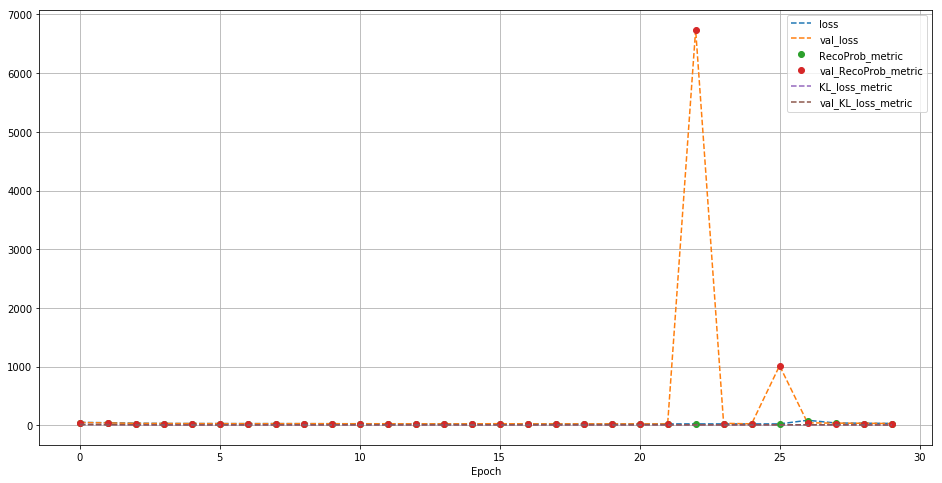

In [19]:
%matplotlib inline
f = plt.figure(figsize=(16,8))
style = {'loss':'--', 'RecoProb_metric': 'o', 'KL_loss_metric': '--'}
for item in ['loss', 'RecoProb_metric', 'KL_loss_metric']:
    plt.plot(np.array(fit_report.history[item][:])[1:], style[item], label=item)
    plt.plot(np.array(fit_report.history['val_'+item][:])[1:], style[item], label='val_'+item)

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')

In [17]:
if 0:
    vae.save(SampleName + '_v3-1_SWAN_VAE.h5')
else:
    from keras.models import load_model
    custom_objects = {
        'original_dim': x_train.shape[1],
        'latent_dim': latent_dim,
        'intermediate_dim': intermediate_dim,
        'act_fun': act_fun,
        'Nf_lognorm' : Nf_lognorm,
        'Nf_gauss' : Nf_gauss,
        'Nf_Pgauss' : Nf_Pgauss,
        'Nf_PDgauss' : Nf_PDgauss,
        'Nf_binomial' : Nf_binomial,
        'Nf_poisson' : Nf_poisson,
        'LossVAE': LossVAE,
        'RecoProb_metric': RecoProb_metric,
        'KL_loss_metric': KL_loss_metric    
    }
    
    vae = load_model(SampleName + '_v3-1_SWAN_VAE.h5', custom_objects=custom_objects)
    print 'Loaded'

Loaded


### Build encoder and decoder

Get prior means and variance array

In [18]:
if 0:
    Prior_Dumper = Model(inputs=x_DNN_input, outputs=[L_prior_mean, L_prior_sigma])
    Prior_Dumper.save(SampleName + '_v3-1_SWAN_prior.h5')
else:
    Prior_Dumper = load_model(SampleName + '_v3-1_SWAN_prior.h5', custom_objects=custom_objects)
    
aux = Prior_Dumper.predict(np.zeros((1, original_dim)))
mu_prior = aux[0][0]
sigma_prior = aux[1][0]

print mu_prior
print sigma_prior

[  2.48727894   4.60984612  11.82443619   0.26881075]
[ 2.1135602   1.89628494  5.22270918  0.18439209]


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
if 0:
    encoder = Model(inputs=x_DNN_input, outputs=[L_z_mean, L_z_sigma])
    encoder.save(SampleName + '_v3-1_SWAN_encoder.h5')
else:
    encoder = load_model(SampleName + '_v3-1_SWAN_encoder.h5', custom_objects=custom_objects)

# Validation

Gather the signal data

In [20]:
x_sig = {}
for n in BSM_samples:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:N_train, sel]

### Predict latent space

In [21]:
x_train_encoded = np.array(encoder.predict(x_train))

x_sig_encoded = {}
for k,v in x_sig.iteritems():
    print k
    x_sig_encoded[k] = np.array(encoder.predict(v))

AtoChHW_HIGHMASS
Ato4l
AtoChHW
Wprime
qcd
Zprime
ttbar


Latent space mean distribution

In [22]:
def sum_of_gaussians(x, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

In [38]:
histos = []
canvases = []
binning = [70, -8, 8]

for kk in range(latent_dim):
    c = rt.TCanvas('c'+str(kk), 'c'+str(kk), 600, 400)

    lower_bound = mu_prior[kk] - 6*sigma_prior[kk]
    upper_bound = mu_prior[kk] + 6*sigma_prior[kk]
    h = rt.TH1F('hSM{}_{}'.format(SampleName, kk), SampleName, binning[0], lower_bound, upper_bound)
    z = x_train_encoded[0, :, kk]
    rtnp.fill_hist(h, z, weights=1/float(z.shape[0])*np.ones_like(z))
    h.SetStats(0)
    h.SetLineColor(rt.kGreen+4-2)
    h.SetFillColorAlpha(rt.kGreen+4-2, 0.7)
    h.SetFillStyle(3001)
    
    h.SetTitle('')
    h.SetXTitle('Mean of z_{'+str(kk)+'}')
    h.SetYTitle('Probability')
    
    h.Draw('Bar SAME')
    histos.append(h)


    colors = [1,2,4,rt.kYellow+2,6,7,8]
    # fill
    for i, n in enumerate(x_sig.keys()):
        h = rt.TH1F('hBSM{}_{}'.format(i, kk), n, binning[0], lower_bound, upper_bound)
        z = x_sig_encoded[n][0, :, kk]
        rtnp.fill_hist(h, z, weights=1/float(z.shape[0])*np.ones_like(z))

        h.SetStats(0)
        h.SetLineColor(colors[i])
        h.SetLineWidth(2)
        h.Draw('SAME')
        histos.append(h)

    c.BuildLegend()
    c.SetGrid()
    c.SetLogy()
    c.Draw()
    canvases.append(c)
    
fout = rt.TFile('plots/'+SampleName + '_v3-1_SWAN_meanZ.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()

## Recostruction sum of pdf

In [24]:
if 0:
    autoencoder = Model(inputs=x_DNN_input, outputs=[L_par1, L_par2, L_par3])
    autoencoder.save(SampleName + '_v3-1_SWAN_autoencoder.h5')
else:
    autoencoder = load_model(SampleName + '_v3-1_SWAN_autoencoder.h5', custom_objects=custom_objects)

In [25]:
pars_ae_train = autoencoder.predict(x_train)
# print pars_ae_train.shape

pars_ae_sig = {}
for k,v in x_sig.iteritems():
    print k
    pars_ae_sig[k] = autoencoder.predict(v)

AtoChHW_HIGHMASS
Ato4l
AtoChHW
Wprime
qcd
Zprime
ttbar


In [26]:
def sum_of_possion(x_in, mu_vec):
    out = np.zeros_like(x_in)
    for i, aux in enumerate(x_in):
        out[i] = np.sum(poisson.pmf(aux, mu_vec))
    return out

In [27]:
def sum_of_lognorm(x, f, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    
    x_clipped = np.clip(x, clip_x_to0, 1e8)
    x_norm = (np.log(x_clipped) - mu_vec)/sigma_vec
    single_prob = np.where(np.less(x, clip_x_to0),
                               f,
                               (1-f)*np.exp(-0.5*np.square(x_norm))/(x_clipped*sigma_vec*np.sqrt(2*np.pi))
    )
    return np.sum(single_prob, axis=1)/mu_vec.shape[0]

In [28]:
from scipy.special import erf
def sum_of_PDgauss(x, mu, sigma):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    
    zp = (x + 0.5 - mu)/sigma
    zm = (x - 0.5 - mu)/sigma
    
    norm_0 = (-0.5 - mu)/sigma
    
    aNorm = 1 + 0.5*(1 + erf(norm_0/np.sqrt(2)))
    single_prob = aNorm*0.5*(erf(zp/np.sqrt(2)) - erf(zm/np.sqrt(2)))
    return np.sum(single_prob, axis=1)/mu.shape[0]

def sum_of_Pgauss(x, mu, sigma):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    norm_0 = - mu/sigma
    aNorm = 1 + 0.5*(1 + erf(norm_0/np.sqrt(2)))
    
    single_prob = aNorm*np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_prob, axis=1)/mu.shape[0]

HT
MET
allJetMass
allMuPt
allElePt
allEleMass
allMuMass
LepPt
LepIsoCh
LepIsoGamma
LepIsoNeu
LepEta
MT
nMu
nJets
bJets
nEle
LepCharge
LepIsEle
nChHad
nNeuHad
nPhoton


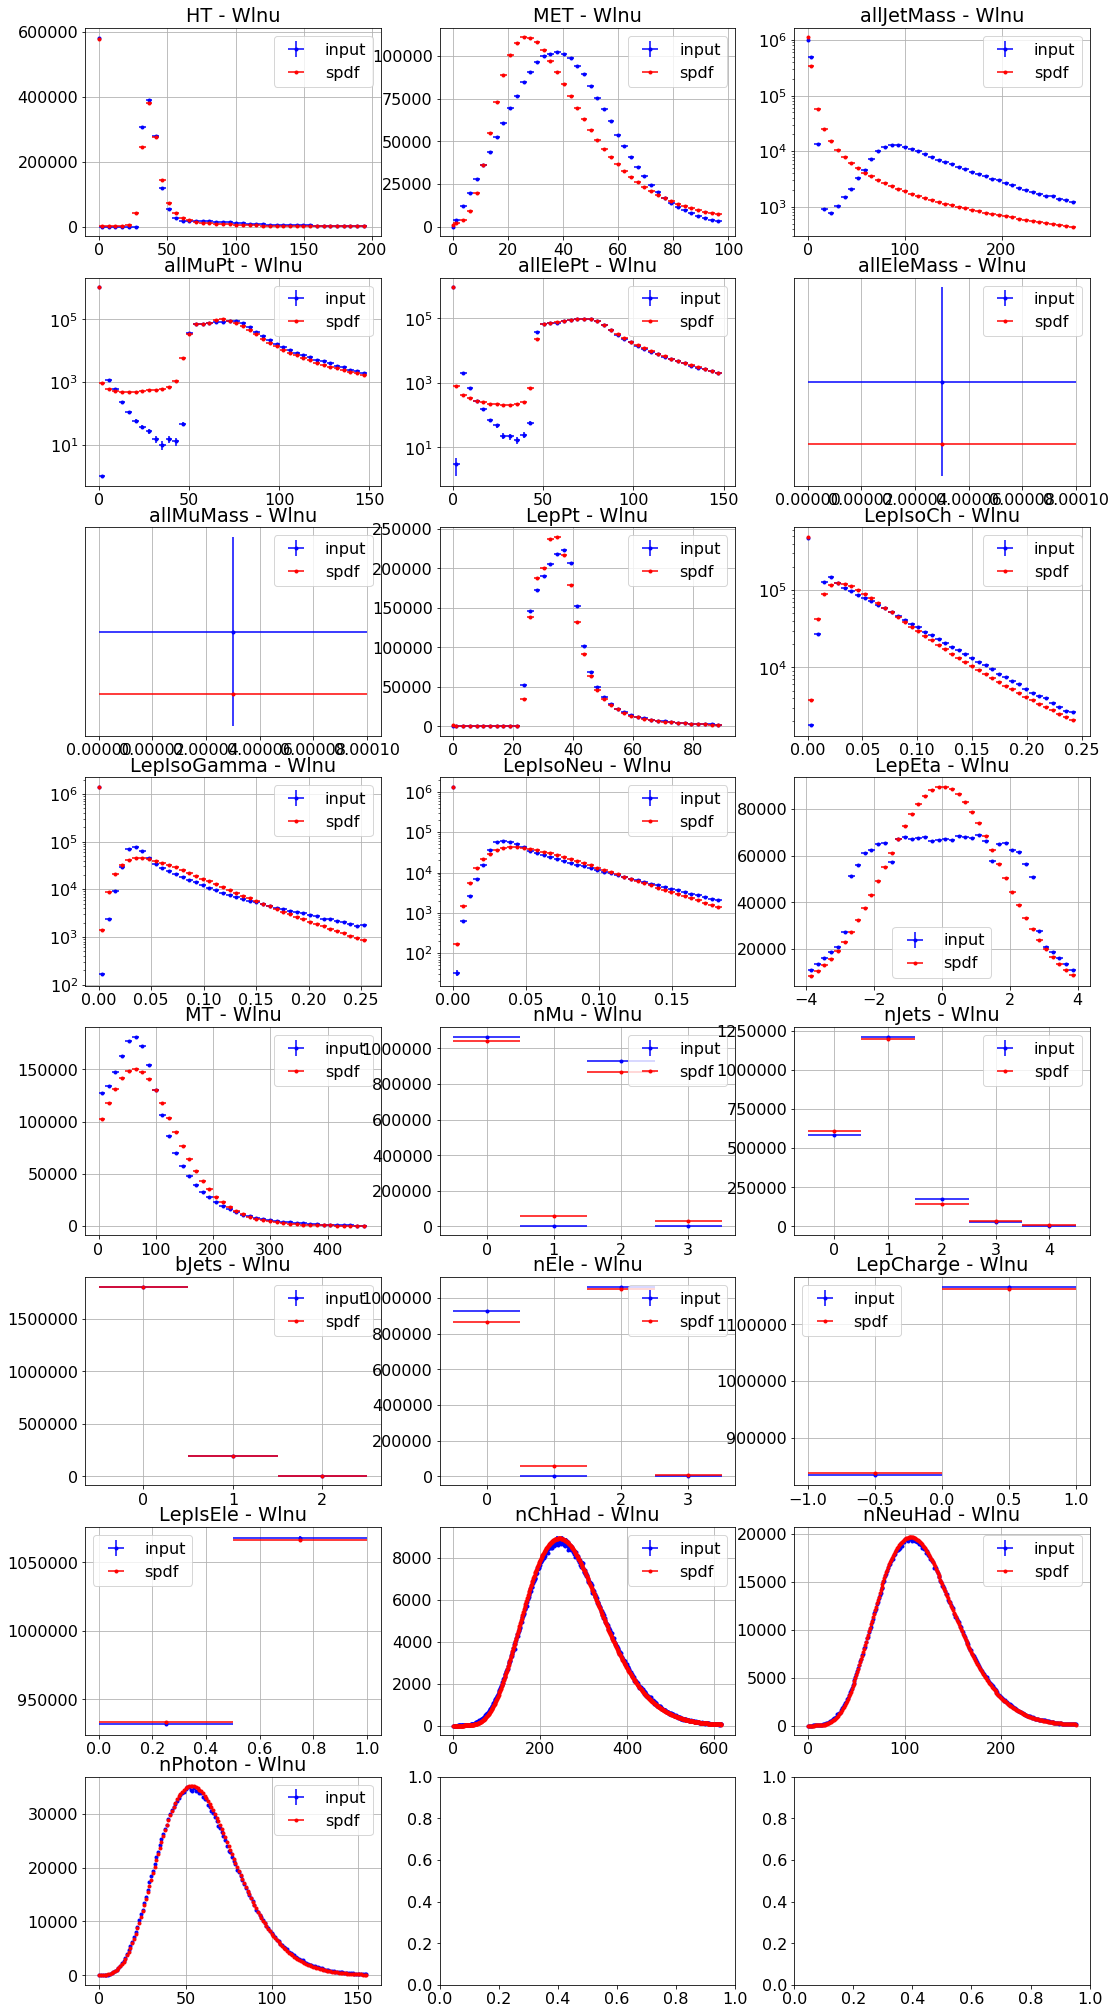

In [39]:
f, ax_arr = plt.subplots(1+int(len(active_hlf_features)/3.),3 , figsize=(18,36))

for i,hlf_name in enumerate(active_hlf_features):
    print hlf_name
#     plt.yscale('log', nonposy='clip')
    
    #Plot distribution of the variable
    x_aux = x_train[:, i]
    if i < Nf_lognorm:
        histo_range = (0, np.percentile(x_aux, 99.))
        bin_content, bin_edges = np.histogram(x_aux, bins=40, range=histo_range)
        if np.sum(bin_edges>clip_x_to0) > 0:
            i_aux = np.argmin(bin_edges<clip_x_to0)
            bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[i_aux:]))
        else:
            bin_edges = np.array([0, clip_x_to0])
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
        bin_width[0] = 1.

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        f_vec = pars_ae_train[2][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=40, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=40, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_Pgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_PDgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss + Nf_binomial:
        bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        p = 0.5*(1+0.98*np.tanh(pars_ae_train[0][:, i]))

        spdf_bin_content = np.zeros_like(bincenters)
        spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
        spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
    else:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        aux = pars_ae_train[0][:, i]
        mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
        spdf_bin_content = sum_of_possion(bincenters, mu_vec)


    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
        
    ax_arr[i/3, i%3].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
    ax_arr[i/3, i%3].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
    ax_arr[i/3, i%3].grid()
    ax_arr[i/3, i%3].set_title(hlf_name + ' - ' + SampleName)        
    ax_arr[i/3, i%3].legend(loc='best')
    
    if hlf_name.startswith('LepIso') or hlf_name.startswith('all'):
        ax_arr[i/3, i%3].set_yscale('log')
        
plt.show()

# Test Statistics with Losses

In [32]:
from scipy.special import loggamma

In [33]:
def numpy_KL_loss(mu, sigma):
    sp = np.atleast_2d(sigma_prior)
    mp = np.atleast_2d(mu_prior)
    kl_loss = np.square(sigma)*np.square(sp)
    kl_loss += np.square((mp - mu)/sp)
    kl_loss += np.log(sp/sigma) -1

    return 0.5 * np.sum(kl_loss, axis=-1)

def numpy_RecoProb(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = np.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = np.where(np.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -np.log(fraction),
                                -np.log(1-fraction)
                                + np.log(sigma) 
                                + np.log(x_clipped)
                                + 0.5*np.square((np.log(x_clipped) - mu) / sigma)
                           )
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = (x[:,N:N+Nf_gauss] - mu)/sigma
    single_NLL = np.log(sigma) + 0.5*np.square(norm_x)
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    # Positive Gaussian distributed variables
    mu = par1[:,N:N+Nf_Pgauss]
    sigma = par2[:,N:N+Nf_Pgauss]
    norm_x = (x[:,N:N+Nf_Pgauss] - mu)/sigma

    sqrt2 = 1.4142135624
    aNorm = 1 + 0.5*(1 + erf( -mu/(sigma*sqrt2) ))
    
    single_NLL = np.log(sigma) + 0.5*np.square(norm_x) - np.log(aNorm)
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_Pgauss
    
    # Positive Discrete Gaussian distributed variables
    mu = par1[:,N:N+Nf_PDgauss]
    sigma = par2[:,N:N+Nf_PDgauss]
    norm_xp = (x[:,N:N+Nf_PDgauss] + 0.5 - mu)/sigma
    norm_xm = (x[:,N:N+Nf_PDgauss] - 0.5 - mu)/sigma
    sqrt2 = 1.4142135624
    single_LL = 0.5*(erf(norm_xp/sqrt2) - erf(norm_xm/sqrt2))
    
    norm_0 = (-0.5 - mu)/sigma
    aNorm = 1 + 0.5*(1 + erf(norm_0/sqrt2))
    
    single_NLL = -np.log(np.clip(single_LL, 1e-10, 1e40)) -np.log(aNorm)
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_PDgauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*np.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -np.where(np.equal(x[:, N: N+Nf_binomial],1), np.log(p), np.log(1-p))
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + np.where(np.greater(aux, 0), aux, aux/np.sqrt(1+np.square(aux)))
    single_NLL = loggamma(x[:, N:]+1).real - x[:, N:]*np.log(mu) + mu
    nll_loss += np.sum(single_NLL, axis=-1)
    
    return nll_loss

def numpy_loss(x, x_encoded, pars_ae):
    mu = x_encoded[0]
    sigma = x_encoded[1]    
    kl_loss = numpy_KL_loss(mu, sigma)
    
    nll_loss = numpy_RecoProb(x, pars_ae[0], pars_ae[1], pars_ae[2])
    
    return [nll_loss + kl_loss, nll_loss, kl_loss]

In [34]:
loss_train = numpy_loss(x_train, x_train_encoded, pars_ae_train)

loss_sig = {}
for n in x_sig.keys():
    print n
    loss_sig[n] = numpy_loss(x_sig[n], x_sig_encoded[n], pars_ae_sig[n])

AtoChHW_HIGHMASS
Ato4l
AtoChHW
Wprime
qcd
Zprime
ttbar


In [35]:
histos = []
canvases = []

for loss_piece in range(3):
    binning = [100, np.min(loss_train[loss_piece]), np.percentile(loss_train[loss_piece], 100*(1-5e-5))]
    print binning
    c = rt.TCanvas('c'+str(loss_piece), 'c'+str(loss_piece), 800, 600)


    h = rt.TH1F('h_loss_SM{}_{}'.format(SampleName, loss_piece), SampleName, binning[0], binning[1], binning[2])
    rtnp.fill_hist(h, loss_train[loss_piece])
    h.Scale(1./loss_train[loss_piece].shape[0])

    h.SetStats(0)
    h.SetLineColor(8)
    h.SetFillColorAlpha(8, 0.7)
    h.SetFillStyle(3001)
    h.Draw('Bar SAME')
    histos.append(h)

    val_to_cut = np.percentile(loss_train[loss_piece], 100*(1-1e-3))
    h.SetTitle(h.GetTitle()+' ({:1.1e})'.format(1e-4))
#     print val_to_cut





    colors = [1,2,4,rt.kYellow+2,6,7, 46]
    # fill
    for i, n in enumerate(x_sig.keys()):
        z = loss_sig[n][loss_piece]
        eff = np.sum(z>val_to_cut)/float(z.shape[0])
#         print n, ': {:1.2e}'.format(eff)
        h1 = rt.TH1F('h_loss_BSM{}_{}'.format(i, loss_piece), n+' ({:1.1e})'.format(eff), binning[0], binning[1], binning[2])
        rtnp.fill_hist(h1, z)
        h1.Scale(1./float(z.shape[0]))

        h1.SetStats(0)
        h1.SetLineColor(colors[i])
        h1.SetLineWidth(2)
        h1.Draw('SAME')
        histos.append(h1)

    c.BuildLegend()
    h.SetTitle('')
    Ytitles = ['Loss tot', 'nll(reco probability)', 'KL divergence']
    h.SetXTitle(Ytitles[loss_piece])
    h.SetYTitle('Probability')

    line = rt.TLine()
    line.SetLineColor(rt.kYellow+1)
    line.SetLineWidth(3)
    line.SetLineStyle(9)
    line.DrawLine(val_to_cut,0, val_to_cut,1)

    c.SetGrid()
    c.SetLogy()
    c.Draw()
    canvases.append(c)
    
fout = rt.TFile('plots/'+SampleName+ '_v3-1_SWAN_losses.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()



[100, 13.782720884566324, 278.09985056809109]
[100, 10.753838766174971, 174.81907275975183]
[100, 1.6671276, 149.75445430495841]


In [36]:
import h5py

fout = h5py.File('losses/'+SampleName+ '_v3-1_array.h5', "w")
fout.create_dataset(SampleName, data=np.array(loss_train))

for k,v in loss_sig.items():
    print k
    fout.create_dataset(k, data=np.array(v))
    
fout.close()

AtoChHW_HIGHMASS
Ato4l
AtoChHW
Wprime
qcd
Zprime
ttbar


In [37]:
f = h5py.File('losses/ttbar_v3-1_array.h5', 'r')
f.keys()

[u'Ato4l',
 u'AtoChHW',
 u'AtoChHW_HIGHMASS',
 u'Wlnu',
 u'Wprime',
 u'Zprime',
 u'qcd',
 u'ttbar']